In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [2]:
BATCH_SIZE = 16
L_RATE = 0.001
EPOCH = 50

# 1) 데이터셋 정의

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
dataset = torchvision.datasets.ImageFolder(root='./train', transform=transform)

In [11]:
print(dataset.classes)

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


In [4]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [13]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


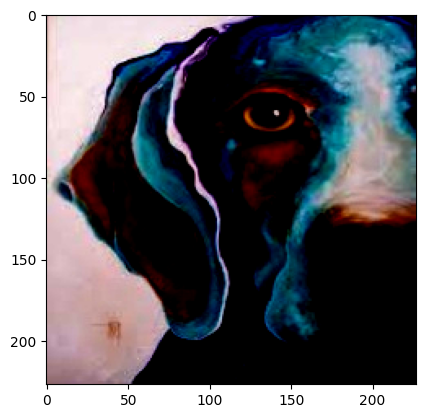

In [12]:
def show_input(sample):
    sample_img = sample[0]
    np_img = sample_img.numpy()
    np_img = np.transpose(np_img, (1,2,0))

    print(dataset.classes[sample[1]])
    plt.imshow(np_img)
    
show_input(dataset.__getitem__(0))

# 2) 모델 정의

In [6]:
class Net(nn.Module):
    def __init__(self, num_classes=7, dr_rate=0.5):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5, stride=2)
        self.conv2 = nn.Conv2d(10, 10, 3, stride=2)
        self.conv3 = nn.Conv2d(10, 10, 3, stride=2)
        self.conv4 = nn.Conv2d(10, 10, 3, stride=2)
        
        self.bn = nn.BatchNorm2d(10)
        
        self.fc1 = nn.Linear(10*13*13, 800)
        self.fc2 = nn.Linear(800, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, num_classes)
        
        self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, x):
            conv_out = F.relu(self.bn(self.conv1(x)))
            conv_out = F.relu(self.bn(self.conv2(conv_out)))
            conv_out = F.relu(self.bn(self.conv3(conv_out)))
            conv_out = F.relu(self.bn(self.conv4(conv_out)))
            
            fc_input = conv_out.view(-1, 10*13*13)
            
            fc_out = F.relu((self.fc1(fc_input)))
            fc_out = self.dropout(fc_out)
            fc_out = F.relu((self.fc2(fc_out)))
            fc_out = self.dropout(fc_out)
            fc_out = F.relu((self.fc3(fc_out)))
            out = self.fc4(fc_out)
            
            return out


# 3) 모델, 손실함수, Optimizer 선언

In [7]:
classifier = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr= L_RATE)

# 4) 모델 학습

In [8]:
for epoch in range(EPOCH):
    classifier.train()
    for batch_idx, (img, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        out = classifier(img)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print("epoch {} Train batch {} loss {:.4f}".format(epoch+1, batch_idx, loss))
            
    classifier.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for img, target in test_loader:
            out = classifier(img)
            
            loss = criterion(out, target)
            test_loss += loss
            
            pred = torch.max(out, 1)[1]
            test_acc += (pred==target).sum().item()
    test_loss /= len(test_loader)
    test_acc = test_acc / len(test_set) * 100
        
    print("epoch {} Validate loss {:.4f} Accuracy: {:.2f}%".format(epoch+1, test_loss, test_acc))

epoch 1 Train batch 0 loss 1.9496
epoch 1 Train batch 10 loss 2.2511
epoch 1 Train batch 20 loss 1.9042
epoch 1 Train batch 30 loss 1.7223
epoch 1 Train batch 40 loss 1.9334
epoch 1 Train batch 50 loss 2.1170
epoch 1 Train batch 60 loss 1.6908
epoch 1 Train batch 70 loss 1.5916
epoch 1 Train batch 80 loss 1.7683
epoch 1 Validate loss 1.8097 Accuracy: 30.88%
epoch 2 Train batch 0 loss 1.6615
epoch 2 Train batch 10 loss 1.7836
epoch 2 Train batch 20 loss 1.9317
epoch 2 Train batch 30 loss 1.8907
epoch 2 Train batch 40 loss 2.0766
epoch 2 Train batch 50 loss 1.6206
epoch 2 Train batch 60 loss 1.8782
epoch 2 Train batch 70 loss 1.9502
epoch 2 Train batch 80 loss 1.6096
epoch 2 Validate loss 1.8933 Accuracy: 30.59%
epoch 3 Train batch 0 loss 1.7678
epoch 3 Train batch 10 loss 1.8804
epoch 3 Train batch 20 loss 1.8413
epoch 3 Train batch 30 loss 1.4556
epoch 3 Train batch 40 loss 1.8783
epoch 3 Train batch 50 loss 1.6031
epoch 3 Train batch 60 loss 1.6002
epoch 3 Train batch 70 loss 1.5730
e